In [1]:
import shutil

# importing the sys module
import sys        

# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split

from datetime import datetime


import diff_pipeline4__config as cfg

from Common.Datasets.Morph2.data_parser import DataParser
from Common.Datasets.Morph2.Morph2ClassifierDataset2 import Morph2ClassifierDataset2
from Common.Datasets.Morph2.Morph2ClassifierDataset3 import Morph2ClassifierDataset3
from diff_pipeline4__train import train_diff_cls_model_iter

from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler


from diff_pipeline4__model import DiffPipeline4Model, DiffPipeline4DeepModel


from Common.Pipelines.AgePredictSingleRefPipeline import AgePredictSingleRefEnhancedPipeline #AgePredictSingleRefPipeline
#from Common.Analysis.DiffAnalysisMethods import diff_pipeline_confusion_matrix_analysis
from Common.Analysis.DiffAnalysisMethods import evaluate_pipeline_clean_enhanced


from tqdm import tqdm


from Common.Models.UnifiedClassificaionAndRegressionAgeModel import UnifiedClassificaionAndRegressionAgeModel
from Common.Models.transformer import *
from Common.Models.unified_transformer_model import AgeTransformer

from sklearn import utils


if __name__ == "__main__":

    torch.manual_seed(cfg.RANDOM_SEED)
    np.random.seed(cfg.RANDOM_SEED)
    random.seed(cfg.RANDOM_SEED)

    if cfg.USE_GPU:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")

    print(device)

    torch.cuda.empty_cache()





    # Load data
    data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
    data_parser.initialize_data()

    x_train, y_train, x_test, y_test = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test,
    if cfg.RANDOM_SPLIT:
        all_images = np.concatenate((x_train, x_test), axis=0)
        all_labels = np.concatenate((y_train, y_test), axis=0)

        x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)



    with open("im2age_map_test.json", 'r') as im2age_map_test_f:
        im2age_map_test = json.load(im2age_map_test_f)

#     transf_age_pred_model = transforms.Compose([
#             transforms.RandomResizedCrop(224, (0.9, 1.0)),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomApply([transforms.ColorJitter(
#                 brightness=0.1,
#                 contrast=0.1,
#                 saturation=0.1,
#                 hue=0.1
#             )], p=0.5),
#             transforms.RandomApply([transforms.RandomAffine(
#                 degrees=10,
#                 translate=(0.1, 0.1),
#                 scale=(0.9, 1.1),
#                 shear=5,
#                 resample=Image.BICUBIC
#             )], p=0.5),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#             transforms.RandomErasing(p=0.5)
#         ])

    transf_diff_model = transforms.Compose([
            transforms.Resize(224), # just for testing
    #          transforms.RandomResizedCrop(224, (0.9, 1.0)),
    #          transforms.RandomHorizontalFlip(),
#             transforms.RandomApply([transforms.ColorJitter(
#                 brightness=0.1,
#                 contrast=0.1,
#                 saturation=0.1,
#                 hue=0.1
#             )], p=0.5),
    #         transforms.RandomApply([transforms.RandomAffine(
    #             degrees=10,
    #             translate=(0.1, 0.1),
    #             scale=(0.9, 1.1),
    #             shear=5,
    #             resample=Image.BICUBIC
    #         )], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #        transforms.RandomErasing(p=0.5)
    ])


    test_ds = Morph2ClassifierDataset3( #Morph2ClassifierDataset Morph2ClassifierDataset2
        x_test,
        y_test,
        cfg.MIN_AGE,
        cfg.AGE_INTERVAL,
        transform=transforms.Compose([
            transforms.Resize(224),
            #transforms.RandomResizedCrop(224, (0.9, 1.0)),
            #transforms.RandomHorizontalFlip(),
#             transforms.RandomApply([transforms.ColorJitter(
#                 brightness=0.1,
#                 contrast=0.1,
#                 saturation=0.1,
#                 hue=0.1
#             )], p=0.5),
#                 transforms.RandomApply([transforms.RandomAffine(
#                     degrees=10,
#                     translate=(0.1, 0.1),
#                     scale=(0.9, 1.1),
#                     shear=5,
#                     resample=Image.BICUBIC
#                 )], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            #transforms.RandomErasing(p=0.5)
        ]),
        copies=cfg.NUM_OF_COPIES_AGE_PREDICT
    )

    train_ds = Morph2ClassifierDataset3( #Morph2ClassifierDataset Morph2ClassifierDataset2
            x_train,
            y_train,
            cfg.MIN_AGE,
            cfg.AGE_INTERVAL,
            transform=transforms.Compose([
                transforms.Resize(224),
                #transforms.RandomResizedCrop(224, (0.9, 1.0)),
                #transforms.RandomHorizontalFlip(),
#                 transforms.RandomApply([transforms.ColorJitter(
#                     brightness=0.1,
#                     contrast=0.1,
#                     saturation=0.1,
#                     hue=0.1
#                 )], p=0.5),
#                 transforms.RandomApply([transforms.RandomAffine(
#                     degrees=10,
#                     translate=(0.1, 0.1),
#                     scale=(0.9, 1.1),
#                     shear=5,
#                     resample=Image.BICUBIC
#                 )], p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                #transforms.RandomErasing(p=0.5)
            ]),
            copies=cfg.NUM_OF_COPIES_AGE_PREDICT
        )

    image_datasets = {
        'train': train_ds,
        'val': test_ds
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    data_loaders = {
        'train': DataLoader(train_ds, batch_size=1, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=False),
        'val': DataLoader(test_ds, batch_size=1, num_workers=cfg.NUM_OF_WORKERS_DATALOADER, pin_memory=True, shuffle=False, drop_last=False)
    }


    num_classes = int((cfg.MAX_AGE - cfg.MIN_AGE) / cfg.AGE_INTERVAL + 1)


    # create model and parameters
    if cfg.DEEP_MODEL:
        model = DiffPipeline4DeepModel
    else:
        model = DiffPipeline4Model

    print("training set size: " + str(len(train_ds)))
    print("testing set size: " + str(len(test_ds)))

    pipeline = AgePredictSingleRefEnhancedPipeline(
                        device,
                        num_classes, 
                        cfg.AGE_INTERVAL, 
                        cfg.MIN_AGE, 
                        cfg.MAX_AGE, 
                        cfg.AGE_RADIUS,
                        cfg.MID_FEATURE_SIZE_AGE_PREDICT, 
                        x_train,
                        y_train,
                        0, #cfg.DEEP, 
                        0, #cfg.NUM_OF_REFERENCES, 
                        0, #cfg.DIFF_MODEL_CONFIG_TYPE, 
                        0, #cfg.ADDED_EMBED_LAYER_SIZE,
                        0, #cfg.DIFF_EMBED_LAYER_SIZE,
                        transf_diff_model,
                        cfg.NUM_OF_COPIES_AGE_PREDICT,
                        UnifiedClassificaionAndRegressionAgeModel,
                        TransformerModel,
                        AgeTransformer,
                        model, #AgeDiffModelNonOpt, #AgeDiffModel,
                        True, #cfg.IS_ORDINAL_REG,
                        no_age_transformer_init=False,
                        cfg=cfg)


    #diff_pipeline_confusion_matrix_analysis(pipeline, data_loaders['val'], device, dataset_sizes['val'], is_ordinal_reg=True)


#     if cfg.CHECK_DIFF_BASED:
#         mae_on_test = evaluate_pipeline_clean_enhanced(pipeline, 
#                                                         data_loaders['val'], 
#                                                         device, 
#                                                         dataset_sizes['val'], 
#                                                         bypass_diff=False, 
#                                                         compare_post_round=False, 
#                                                         range_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, 
#                                                         range_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI, 
#                                                         im2age_map_test=im2age_map_test, 
#                                                         check_against_pred_db=False)
#     else:
#         mae_on_test = evaluate_pipeline_clean_enhanced(pipeline, 
#                                                     data_loaders['val'], 
#                                                     device, 
#                                                     dataset_sizes['val'], 
#                                                     bypass_diff=True, 
#                                                     compare_post_round=False, 
#                                                     range_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, 
#                                                     range_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI, 
#                                                     im2age_map_test=im2age_map_test, 
#                                                     check_im2age_map_test=False,
#                                                     create_im2age_map_test=False, 
#                                                     check_against_pred_db=False)
#         #mae_on_test = evaluate_pipeline_clean_enhanced(pipeline, data_loaders['val'], device, dataset_sizes['val'], bypass_diff=True, compare_post_round=False, range_lo=cfg.AGE_DIFF_LEARN_RADIUS_LO, range_hi=cfg.AGE_DIFF_LEARN_RADIUS_HI, im2age_map_test=im2age_map_test)



cpu
training set size: 44285
testing set size: 10606


In [2]:
age_pred_model = pipeline.get_age_orig_model()
age_pred_model

AgeTransformer(
  (backbone): FeatureExtractionVgg16(
    (base_net): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=

In [3]:
if cfg.MULTI_GPU:
    print(age_pred_model.module.backbone.base_net)
else:
    print(age_pred_model.backbone.base_net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [5]:
if cfg.MULTI_GPU:
    age_pred_model.module.backbone.register_forward_hook(get_features('backbone'))
else:
    age_pred_model.backbone.register_forward_hook(get_features('backbone'))

In [7]:
# for i in range(len(test_ds)):
#     if i % 100 == 0:
#         print("--")
#     #print(test_ds[i]['age'])
#     if test_ds[i]['age'] == 30:
#         print(i)

# Some Similarity Check With Embeddings

 24%|██████████████████▍                                                          | 2540/10606 [00:54<02:32, 52.97it/s]D:\projects\age_estimation\DiffPipeline4\..\Common\Models\transformer.py:127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = nn.Softmax()(classification_logits)
100%|████████████████████████████████████████████████████████████████████████████| 10606/10606 [08:18<00:00, 21.26it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 223 samples in 0.000s...
[t-SNE] Computed neighbors for 223 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 223 / 223
[t-SNE] Mean sigma: 24.054001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.088684
[t-SNE] KL divergence after 900 iterations: 0.454723


[Text(0.5, 1.0, 'Age Diff data T-SNE projection')]

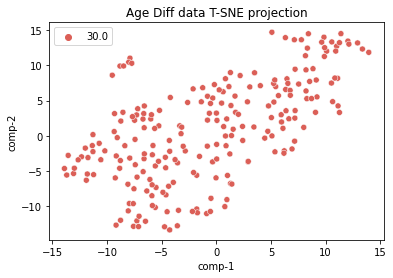

In [13]:
ages_cat = np.array([])
feats = np.array([]).reshape(0, 4096)
#face2emb_map_vld = {}
faces_cat = np.array([]).reshape(0, 224, 224, 3)
for i, batch in enumerate(tqdm(data_loaders['val'])):
    ages_cat_cur = batch['age'].numpy()
    if ages_cat_cur == 30.0:
        faces = batch['image']
        ages_cat = np.concatenate((ages_cat, ages_cat_cur), axis=0)
        output = age_pred_model(faces)
        # taking copy 0
        feats_cur = features['backbone'][0].numpy().reshape(1, 4096)
    #     import pdb
    #     pdb.set_trace()
        #face2emb_map_vld[int(batch['idx'])] = feats_cur
        feats = np.concatenate((feats, feats_cur), axis=0)
        faces_cat = np.concatenate((faces_cat, faces[0][0].permute(1, 2, 0).numpy().reshape(1, 224, 224, 3)), axis=0)



#     if i == 20:
#         break


from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(feats)
df = pd.DataFrame()
df["y"] = ages_cat
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(np.unique(ages_cat))),
                data=df).set(title="Age Diff data T-SNE projection")

In [14]:
feats.shape
faces_cat.shape

(223, 224, 224, 3)

In [15]:
for i in range(feats.shape[0]):
    for j in range(feats.shape[0]):
        d = np.linalg.norm(feats[i] - feats[j]) 
        if d > 200 or d < 50:
            print(d, i, j, ages_cat[i], ages_cat[j])

0.0 0 0 30.0 30.0
45.23835930271145 0 1 30.0 30.0
48.95829310292583 0 16 30.0 30.0
256.5938977171681 0 20 30.0 30.0
256.5721491091167 0 39 30.0 30.0
286.78512082852995 0 83 30.0 30.0
219.48731913077316 0 152 30.0 30.0
242.56718514731597 0 157 30.0 30.0
260.58486414051816 0 216 30.0 30.0
45.23835930271145 1 0 30.0 30.0
0.0 1 1 30.0 30.0
265.1512325898658 1 20 30.0 30.0
205.85163765882393 1 27 30.0 30.0
208.4919941018288 1 28 30.0 30.0
262.3649818545783 1 39 30.0 30.0
290.64304494913176 1 83 30.0 30.0
202.45518952032177 1 84 30.0 30.0
228.7076791595183 1 152 30.0 30.0
247.17907640982006 1 157 30.0 30.0
268.34405060109657 1 216 30.0 30.0
0.0 2 2 30.0 30.0
48.727078852028065 2 12 30.0 30.0
287.22208057590285 2 20 30.0 30.0
224.9768292661306 2 27 30.0 30.0
227.5245357807651 2 28 30.0 30.0
205.51568028794424 2 37 30.0 30.0
264.43316005868417 2 39 30.0 30.0
281.73036944237 2 83 30.0 30.0
220.95294207194735 2 119 30.0 30.0
256.9481088257166 2 152 30.0 30.0
239.65118268523975 2 157 30.0 30.0
30

49.3314845539514 19 121 30.0 30.0
38.79901311098241 19 133 30.0 30.0
202.08841566707738 19 140 30.0 30.0
232.63561256423128 19 152 30.0 30.0
203.46387626831546 19 157 30.0 30.0
32.72500861050049 19 165 30.0 30.0
43.070809125262386 19 184 30.0 30.0
36.53420066602129 19 185 30.0 30.0
30.76901009524174 19 186 30.0 30.0
44.60083126606559 19 188 30.0 30.0
37.29060106633108 19 201 30.0 30.0
34.07741411293861 19 203 30.0 30.0
33.67724592527597 19 204 30.0 30.0
286.8022638841386 19 216 30.0 30.0
49.93978985391547 19 219 30.0 30.0
256.5938977171681 20 0 30.0 30.0
265.1512325898658 20 1 30.0 30.0
287.22208057590285 20 2 30.0 30.0
223.69343315434654 20 3 30.0 30.0
211.92240871340755 20 4 30.0 30.0
212.44492793809872 20 5 30.0 30.0
246.70736731694234 20 6 30.0 30.0
242.16562387356865 20 7 30.0 30.0
233.4381786314681 20 8 30.0 30.0
270.12856642805247 20 10 30.0 30.0
317.5627191253364 20 11 30.0 30.0
280.04632221157647 20 12 30.0 30.0
285.77856230037327 20 13 30.0 30.0
273.90042392991677 20 14 30.0 

29.590034943904023 26 65 30.0 30.0
30.34963837066788 26 66 30.0 30.0
24.905991342267345 26 67 30.0 30.0
30.01526125178241 26 73 30.0 30.0
36.595238874556244 26 74 30.0 30.0
207.40138249598996 26 83 30.0 30.0
49.63411862289104 26 85 30.0 30.0
36.727539462761904 26 90 30.0 30.0
49.018209116633074 26 92 30.0 30.0
35.48222249060437 26 98 30.0 30.0
41.95774255796573 26 101 30.0 30.0
45.42038755374796 26 105 30.0 30.0
44.1489395443715 26 112 30.0 30.0
29.728658018773718 26 121 30.0 30.0
41.55589278298453 26 125 30.0 30.0
205.5479518817442 26 140 30.0 30.0
203.53196055603135 26 152 30.0 30.0
49.184417520524505 26 154 30.0 30.0
46.101713134877485 26 168 30.0 30.0
45.54417336045913 26 172 30.0 30.0
42.95556737055628 26 184 30.0 30.0
27.84613050676691 26 189 30.0 30.0
30.65406470829812 26 190 30.0 30.0
36.71970622349527 26 191 30.0 30.0
32.38539317079626 26 199 30.0 30.0
251.65749964437103 26 216 30.0 30.0
42.19344313880623 26 217 30.0 30.0
205.85163765882393 27 1 30.0 30.0
224.9768292661306 27 

263.74422827884484 36 157 30.0 30.0
207.57812086071058 36 177 30.0 30.0
276.2058851908625 36 216 30.0 30.0
205.51568028794424 37 2 30.0 30.0
247.48394683812631 37 11 30.0 30.0
211.4659049706475 37 13 30.0 30.0
46.172744530171215 37 27 30.0 30.0
209.15422212017037 37 32 30.0 30.0
210.85423231072542 37 33 30.0 30.0
37.757667808047856 37 35 30.0 30.0
0.0 37 37 30.0 30.0
211.96259739217547 37 47 30.0 30.0
208.13680414592767 37 57 30.0 30.0
46.49953164726008 37 62 30.0 30.0
206.6812688552482 37 83 30.0 30.0
205.2185453155434 37 93 30.0 30.0
214.5222178251129 37 96 30.0 30.0
209.92193698407806 37 166 30.0 30.0
203.7900175545774 38 11 30.0 30.0
34.50401407495193 38 19 30.0 30.0
257.0989040688883 38 20 30.0 30.0
30.141488993768764 38 25 30.0 30.0
47.37256502687694 38 26 30.0 30.0
43.13613291076496 38 29 30.0 30.0
47.46736940769806 38 31 30.0 30.0
38.096811643176686 38 34 30.0 30.0
0.0 38 38 30.0 30.0
224.82277697901793 38 39 30.0 30.0
49.64316750950635 38 65 30.0 30.0
40.104114046615194 38 66 

294.1968463800152 47 83 30.0 30.0
206.5440915823837 47 84 30.0 30.0
219.9966750837909 47 119 30.0 30.0
211.54569885345225 47 149 30.0 30.0
257.1078203236944 47 152 30.0 30.0
209.85899288103323 47 156 30.0 30.0
253.39349199603757 47 157 30.0 30.0
296.39524202962997 47 216 30.0 30.0
201.24271509098486 48 20 30.0 30.0
38.93637577578246 48 43 30.0 30.0
45.40938041493395 48 44 30.0 30.0
40.95931335332151 48 45 30.0 30.0
0.0 48 48 30.0 30.0
43.17482436903847 48 58 30.0 30.0
46.35321551607765 48 61 30.0 30.0
45.22067731670959 48 69 30.0 30.0
49.882526923900116 48 77 30.0 30.0
41.33231226554255 48 81 30.0 30.0
231.2921230122987 48 83 30.0 30.0
34.02166097185898 48 88 30.0 30.0
45.84412549568227 48 102 30.0 30.0
44.11468779049819 48 109 30.0 30.0
35.22952569712706 48 123 30.0 30.0
47.87640039760702 48 124 30.0 30.0
47.42621444270979 48 125 30.0 30.0
42.64986531736256 48 127 30.0 30.0
39.045597698641124 48 137 30.0 30.0
37.017197617855224 48 139 30.0 30.0
48.34036598530603 48 161 30.0 30.0
49.49

201.75090366585317 63 20 30.0 30.0
236.85202854332465 63 39 30.0 30.0
0.0 63 63 30.0 30.0
277.4692255097211 63 83 30.0 30.0
232.18913573286451 63 157 30.0 30.0
203.90491906399112 63 216 30.0 30.0
241.82987151408025 64 20 30.0 30.0
233.36158931810525 64 39 30.0 30.0
0.0 64 64 30.0 30.0
266.5800087047003 64 83 30.0 30.0
43.59838775865204 64 87 30.0 30.0
209.21537117691886 64 152 30.0 30.0
220.67663019571654 64 157 30.0 30.0
243.4925282624589 64 216 30.0 30.0
40.445086798553326 64 218 30.0 30.0
49.88842530763829 64 222 30.0 30.0
207.99240466793682 65 11 30.0 30.0
214.8119417331126 65 20 30.0 30.0
29.590034943904023 65 26 30.0 30.0
23.219922676083254 65 31 30.0 30.0
43.14150103088073 65 34 30.0 30.0
49.64316750950635 65 38 30.0 30.0
49.7441647204255 65 44 30.0 30.0
34.82861536691702 65 45 30.0 30.0
0.0 65 65 30.0 30.0
36.68133627151622 65 66 30.0 30.0
36.56034641462733 65 67 30.0 30.0
45.5619467392769 65 69 30.0 30.0
43.90105964016458 65 73 30.0 30.0
38.6128027178411 65 74 30.0 30.0
221.01

31.46175197807564 74 66 30.0 30.0
37.71229435485395 74 67 30.0 30.0
43.71198836781187 74 73 30.0 30.0
0.0 74 74 30.0 30.0
222.5936135446887 74 83 30.0 30.0
28.186067266227898 74 90 30.0 30.0
42.17968190998151 74 98 30.0 30.0
47.87781648568483 74 99 30.0 30.0
31.58721735193001 74 101 30.0 30.0
40.857935219728475 74 105 30.0 30.0
33.41636690051329 74 121 30.0 30.0
37.50362832648458 74 125 30.0 30.0
48.605866519707334 74 133 30.0 30.0
200.86848324144034 74 152 30.0 30.0
43.660925030042755 74 154 30.0 30.0
36.48057648230556 74 168 30.0 30.0
47.900513312458784 74 184 30.0 30.0
46.707459039066904 74 185 30.0 30.0
39.39578722577019 74 189 30.0 30.0
37.83734274030796 74 190 30.0 30.0
47.01389860372336 74 191 30.0 30.0
45.2610942675704 74 201 30.0 30.0
46.381428764900534 74 203 30.0 30.0
250.55287008801722 74 216 30.0 30.0
35.93504827545887 74 217 30.0 30.0
47.9668215424606 74 220 30.0 30.0
34.69408548452339 75 19 30.0 30.0
278.570634817368 75 20 30.0 30.0
39.47016519558054 75 25 30.0 30.0
214.

211.18673493716182 84 14 30.0 30.0
210.31402466883736 84 16 30.0 30.0
200.8241502563141 84 32 30.0 30.0
223.1931494116671 84 36 30.0 30.0
206.5440915823837 84 47 30.0 30.0
0.0 84 84 30.0 30.0
200.50138946122527 84 103 30.0 30.0
231.86056763876215 84 135 30.0 30.0
234.01404304754033 84 140 30.0 30.0
220.51943503768987 84 155 30.0 30.0
214.52516030921674 84 216 30.0 30.0
226.12976441255796 85 11 30.0 30.0
49.63411862289104 85 26 30.0 30.0
49.82609453368186 85 30 30.0 30.0
47.36107954972956 85 50 30.0 30.0
45.350986419890305 85 82 30.0 30.0
0.0 85 85 30.0 30.0
38.10684402167824 85 110 30.0 30.0
46.94714597145623 85 112 30.0 30.0
203.05245422915095 85 135 30.0 30.0
208.27393451421315 85 140 30.0 30.0
34.14685444431762 85 160 30.0 30.0
34.964967207547645 85 167 30.0 30.0
37.18269228755177 85 169 30.0 30.0
48.276280218955634 85 172 30.0 30.0
46.18918250476194 85 189 30.0 30.0
48.57045676421958 85 191 30.0 30.0
38.115809167075355 85 198 30.0 30.0
46.39587740884571 85 215 30.0 30.0
224.3114008

43.47589776647564 98 65 30.0 30.0
40.066441374969976 98 66 30.0 30.0
37.78633193390619 98 67 30.0 30.0
37.14911413227695 98 73 30.0 30.0
42.17968190998151 98 74 30.0 30.0
204.7191052252955 98 83 30.0 30.0
39.46338954552657 98 90 30.0 30.0
0.0 98 98 30.0 30.0
36.12186860834049 98 99 30.0 30.0
41.68905055758004 98 101 30.0 30.0
48.528198857576264 98 105 30.0 30.0
42.66587359332199 98 121 30.0 30.0
49.27449749618816 98 184 30.0 30.0
43.607786192488184 98 189 30.0 30.0
47.46874307826592 98 190 30.0 30.0
41.68428866572767 98 191 30.0 30.0
47.03154904118525 98 199 30.0 30.0
245.223327889452 98 216 30.0 30.0
204.24699625186102 99 11 30.0 30.0
220.5555548434738 99 20 30.0 30.0
47.87781648568483 99 74 30.0 30.0
213.96199617119143 99 83 30.0 30.0
36.12186860834049 99 98 30.0 30.0
0.0 99 99 30.0 30.0
42.25054962123174 99 101 30.0 30.0
47.769913682024324 99 132 30.0 30.0
200.3883745582787 99 152 30.0 30.0
46.26425991157339 99 168 30.0 30.0
244.6004867878435 99 216 30.0 30.0
264.04292461564097 100 

238.71127149583296 113 157 30.0 30.0
47.73861201513707 113 178 30.0 30.0
271.72333432546793 113 216 30.0 30.0
240.7799590367285 114 11 30.0 30.0
202.95621328186343 114 13 30.0 30.0
48.12256076349658 114 35 30.0 30.0
42.581261582689436 114 62 30.0 30.0
208.81422645444454 114 83 30.0 30.0
201.29823803353796 114 96 30.0 30.0
0.0 114 114 30.0 30.0
47.16024129133214 114 180 30.0 30.0
240.90932128200328 115 20 30.0 30.0
232.99293671859257 115 39 30.0 30.0
261.6519950943065 115 83 30.0 30.0
0.0 115 115 30.0 30.0
207.03338909504595 115 152 30.0 30.0
215.0170281067301 115 157 30.0 30.0
42.83578157708986 115 158 30.0 30.0
47.267010562117925 115 164 30.0 30.0
49.165153238443246 115 193 30.0 30.0
251.46508584244978 115 216 30.0 30.0
210.50073652288435 116 11 30.0 30.0
49.20401120803337 116 30 30.0 30.0
49.6388286378262 116 31 30.0 30.0
48.966183314544 116 43 30.0 30.0
37.614772499104234 116 44 30.0 30.0
44.18802825278512 116 45 30.0 30.0
43.24843161657329 116 58 30.0 30.0
40.600367345040645 116 65

43.2189341837004 124 163 30.0 30.0
48.08274747130912 124 176 30.0 30.0
47.1737901618405 124 193 30.0 30.0
237.25304538163874 124 216 30.0 30.0
44.438690875301425 124 217 30.0 30.0
44.860945397570745 124 220 30.0 30.0
200.46319287418 125 11 30.0 30.0
219.5004851732814 125 20 30.0 30.0
41.55589278298453 125 26 30.0 30.0
36.17918138790447 125 31 30.0 30.0
46.76111824850303 125 34 30.0 30.0
47.74634652505683 125 38 30.0 30.0
46.209966896072274 125 41 30.0 30.0
33.16262944085582 125 45 30.0 30.0
47.42621444270979 125 48 30.0 30.0
34.42502602953952 125 65 30.0 30.0
42.169044350149555 125 66 30.0 30.0
47.807839054630854 125 67 30.0 30.0
48.196394838517286 125 68 30.0 30.0
41.78861506904113 125 69 30.0 30.0
37.50362832648458 125 74 30.0 30.0
43.432291594242024 125 77 30.0 30.0
225.6016357126431 125 83 30.0 30.0
45.02157857487132 125 88 30.0 30.0
40.205271186062554 125 90 30.0 30.0
44.62412623939062 125 101 30.0 30.0
40.28358698220723 125 105 30.0 30.0
44.25036387995138 125 109 30.0 30.0
47.149

0.0 139 139 30.0 30.0
42.87857255627442 139 196 30.0 30.0
201.80324531568175 139 216 30.0 30.0
202.08841566707738 140 19 30.0 30.0
253.17983851373853 140 20 30.0 30.0
205.5479518817442 140 26 30.0 30.0
206.15435798979763 140 27 30.0 30.0
205.18908168767362 140 28 30.0 30.0
203.8228265422503 140 30 30.0 30.0
214.25490723534443 140 34 30.0 30.0
203.92736682714877 140 38 30.0 30.0
271.7346292514307 140 39 30.0 30.0
215.23054413608352 140 50 30.0 30.0
228.42962455227706 140 51 30.0 30.0
204.46889449325886 140 66 30.0 30.0
209.67803197778727 140 67 30.0 30.0
210.37656918442195 140 73 30.0 30.0
212.95448463980702 140 75 30.0 30.0
211.06412526187555 140 82 30.0 30.0
313.6129232793656 140 83 30.0 30.0
234.01404304754033 140 84 30.0 30.0
208.27393451421315 140 85 30.0 30.0
211.25918333734876 140 92 30.0 30.0
214.87987408604158 140 93 30.0 30.0
207.07899238467027 140 110 30.0 30.0
222.50597388953068 140 112 30.0 30.0
0.0 140 140 30.0 30.0
222.47209194722043 140 149 30.0 30.0
226.88289374509694 1

0.0 153 153 30.0 30.0
48.430772083062294 153 180 30.0 30.0
48.85674068069837 153 182 30.0 30.0
46.8283243646664 153 183 30.0 30.0
221.21771881870728 154 20 30.0 30.0
41.11840422399378 154 22 30.0 30.0
49.184417520524505 154 26 30.0 30.0
43.172043585911666 154 31 30.0 30.0
205.22423725370547 154 39 30.0 30.0
48.608366750772255 154 41 30.0 30.0
37.27357818307118 154 45 30.0 30.0
41.271254494345 154 65 30.0 30.0
48.93836323893821 154 66 30.0 30.0
46.677445527406 154 68 30.0 30.0
47.15057343809103 154 69 30.0 30.0
43.660925030042755 154 74 30.0 30.0
41.322520111732985 154 77 30.0 30.0
46.10396283844069 154 80 30.0 30.0
231.07793055276096 154 83 30.0 30.0
47.62490699865709 154 90 30.0 30.0
49.31469250337329 154 95 30.0 30.0
43.27942507450206 154 101 30.0 30.0
49.57424063501892 154 105 30.0 30.0
47.93305848938938 154 109 30.0 30.0
43.28342221561308 154 121 30.0 30.0
31.724074914943127 154 125 30.0 30.0
0.0 154 154 30.0 30.0
49.37745791668031 154 165 30.0 30.0
43.71809204011948 154 168 30.0 3

45.181688146484994 167 44 30.0 30.0
45.408125688203775 167 50 30.0 30.0
38.421934910995255 167 82 30.0 30.0
34.964967207547645 167 85 30.0 30.0
34.90964226307206 167 110 30.0 30.0
47.10424464947375 167 116 30.0 30.0
201.8692635050332 167 140 30.0 30.0
43.159790039044736 167 160 30.0 30.0
0.0 167 167 30.0 30.0
25.989837898096273 167 169 30.0 30.0
46.717657748229 167 191 30.0 30.0
44.89059755056827 167 197 30.0 30.0
31.296723876113088 167 198 30.0 30.0
45.28681841141956 167 211 30.0 30.0
47.42308179918186 167 214 30.0 30.0
39.74739335974287 167 215 30.0 30.0
204.18449674066198 167 216 30.0 30.0
224.49561781041874 168 20 30.0 30.0
49.181054888627166 168 25 30.0 30.0
46.101713134877485 168 26 30.0 30.0
40.24934118459344 168 31 30.0 30.0
49.769615959775315 168 38 30.0 30.0
201.51523962011993 168 39 30.0 30.0
45.921535291472644 168 41 30.0 30.0
37.1508625043262 168 45 30.0 30.0
41.00887185393397 168 65 30.0 30.0
43.13424430433167 168 66 30.0 30.0
48.58492089956765 168 68 30.0 30.0
43.7874212

204.55406035777204 187 11 30.0 30.0
220.5440540296047 187 83 30.0 30.0
49.641978223644834 187 116 30.0 30.0
49.72265500137061 187 183 30.0 30.0
0.0 187 187 30.0 30.0
45.20823989025028 187 206 30.0 30.0
49.72893829509393 187 207 30.0 30.0
215.04076029193877 187 216 30.0 30.0
44.60083126606559 188 19 30.0 30.0
270.0043117705796 188 20 30.0 30.0
42.347738198721586 188 24 30.0 30.0
43.74435066456338 188 25 30.0 30.0
204.80080218758866 188 27 30.0 30.0
208.11195027610535 188 28 30.0 30.0
25.577297763937178 188 29 30.0 30.0
49.24062873015552 188 38 30.0 30.0
244.84300257480552 188 39 30.0 30.0
46.6135516383826 188 40 30.0 30.0
49.87604843739555 188 41 30.0 30.0
40.543629323299385 188 55 30.0 30.0
39.311094704453936 188 60 30.0 30.0
37.34523850227105 188 68 30.0 30.0
43.670096476670864 188 75 30.0 30.0
261.8998249232174 188 83 30.0 30.0
35.908242937465516 188 89 30.0 30.0
46.872258471477295 188 91 30.0 30.0
38.69340949081712 188 94 30.0 30.0
49.89904480458453 188 95 30.0 30.0
46.8446395381934

209.94287252085857 202 27 30.0 30.0
213.54995722521 202 28 30.0 30.0
47.71999334367267 202 29 30.0 30.0
250.55089594292238 202 39 30.0 30.0
47.6817034314619 202 40 30.0 30.0
44.98981510522515 202 52 30.0 30.0
43.681470651185954 202 55 30.0 30.0
41.7387028544216 202 60 30.0 30.0
46.44376701612754 202 71 30.0 30.0
268.27375332472263 202 83 30.0 30.0
38.26998440474453 202 89 30.0 30.0
49.5038078976717 202 118 30.0 30.0
209.53688930778503 202 119 30.0 30.0
49.41882048549541 202 126 30.0 30.0
48.28602565106652 202 143 30.0 30.0
39.78816103460631 202 145 30.0 30.0
42.160376417546104 202 146 30.0 30.0
243.98385464137704 202 152 30.0 30.0
223.19946365467527 202 157 30.0 30.0
44.56094910686922 202 188 30.0 30.0
47.96337368543045 202 194 30.0 30.0
0.0 202 202 30.0 30.0
49.57626873576197 202 212 30.0 30.0
292.4508737585527 202 216 30.0 30.0
34.07741411293861 203 19 30.0 30.0
255.66047828076557 203 20 30.0 30.0
49.48804153415261 203 24 30.0 30.0
27.418037689824008 203 25 30.0 30.0
36.9542394266504

209.40792401779296 216 82 30.0 30.0
266.6692631007145 216 83 30.0 30.0
214.52516030921674 216 84 30.0 30.0
224.31140089259492 216 85 30.0 30.0
251.9650336042629 216 86 30.0 30.0
257.45240288951567 216 87 30.0 30.0
212.40288870511714 216 88 30.0 30.0
287.64035131728156 216 89 30.0 30.0
243.75539813357008 216 90 30.0 30.0
268.1814514106146 216 91 30.0 30.0
287.48487226792577 216 92 30.0 30.0
310.3361494763406 216 93 30.0 30.0
285.6999789932849 216 94 30.0 30.0
265.4248507942376 216 95 30.0 30.0
309.687529843665 216 96 30.0 30.0
276.8879753173 216 97 30.0 30.0
245.223327889452 216 98 30.0 30.0
244.6004867878435 216 99 30.0 30.0
278.7521222065542 216 100 30.0 30.0
260.26200139799465 216 101 30.0 30.0
223.07630283240195 216 102 30.0 30.0
268.7041653965263 216 103 30.0 30.0
213.23683597838152 216 104 30.0 30.0
235.41132511791884 216 105 30.0 30.0
253.9182752285721 216 106 30.0 30.0
238.63052625173896 216 107 30.0 30.0
230.17446988927279 216 109 30.0 30.0
220.23790415173139 216 110 30.0 30.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


300.7214065546776


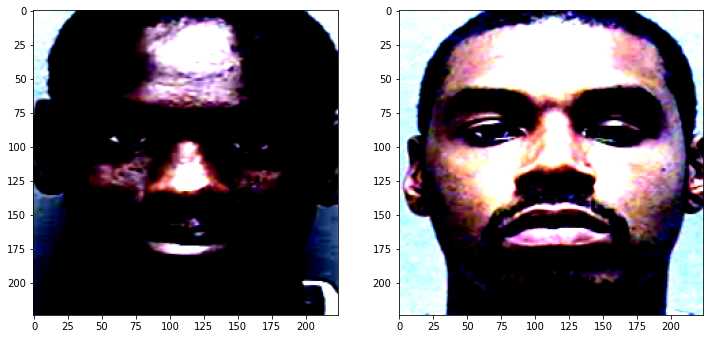

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
#924.8904990107953 2 150 33.0 33.0
id_im1 = 40#7#6#20
id_im2 = 216#83#216#222
# im1 = test_ds[id_im1]['image'][0].permute(1, 2, 0).numpy()
# im2 = test_ds[id_im2]['image'][0].permute(1, 2, 0).numpy()
im1 = faces_cat[id_im1].reshape((224,224,3))
im2 = faces_cat[id_im2].reshape((224,224,3))
ax[0].imshow(im1)#.reshape((224,224,3)))
ax[1].imshow(im2)#.reshape((224,224,3)))
print(np.linalg.norm(feats[id_im1] - feats[id_im2]))
#print(np.linalg.norm(face2emb_map_vld_r[id_im1] - face2emb_map_vld_r[id_im2]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45.087884959925155


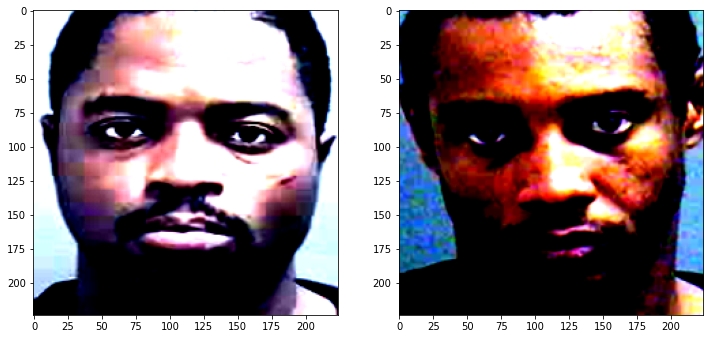

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
#924.8904990107953 2 150 33.0 33.0
id_im1 = 12#6#4#222
id_im2 = 57#210#5#158
# im1 = test_ds[id_im1]['image'][0].permute(1, 2, 0).numpy()
# im2 = test_ds[id_im2]['image'][0].permute(1, 2, 0).numpy()
im1 = faces_cat[id_im1].reshape((224,224,3))
im2 = faces_cat[id_im2].reshape((224,224,3))
ax[0].imshow(im1)#.reshape((224,224,3)))
ax[1].imshow(im2)#.reshape((224,224,3)))
print(np.linalg.norm(feats[id_im1] - feats[id_im2]))
#print(np.linalg.norm(face2emb_map_vld_r[id_im1] - face2emb_map_vld_r[id_im2]))

In [62]:
#np.where(np.linalg.norm(feats[0] - feats) <= 
#np.linalg.norm((feats[0]-feats), axis=1)
#np.percentile(np.linalg.norm((feats[0]-feats), axis=1), 5)
np.where(np.linalg.norm(feats[0] - feats, axis=1) <= np.percentile(np.linalg.norm((feats[0]-feats), axis=1), 5))[0]
#np.linalg.norm(feats[0] - feats[2])

12

# Saving Embeddings From Map Files To Arrays (Not Related to above)

In [6]:
face2emb_map_vld_r = np.load('face2emb_map_vld.npy', allow_pickle=True)
face2emb_map_vld_r = face2emb_map_vld_r.item()

In [69]:
face2emb_arr_vld_r = []
for i in range(len(face2emb_map_vld_r)):
    face2emb_arr_vld_r.append(face2emb_map_vld_r[i])

In [73]:
np.save('face2emb_arr_vld.npy', np.array(face2emb_arr_vld_r))

In [74]:
face2emb_map_trn_r = np.load('face2emb_map_trn.npy', allow_pickle=True)
face2emb_map_trn_r = face2emb_map_trn_r.item()

In [75]:
face2emb_arr_trn_r = []
for i in range(len(face2emb_map_trn_r)):
    face2emb_arr_trn_r.append(face2emb_map_trn_r[i])

In [76]:
np.save('face2emb_arr_trn.npy', np.array(face2emb_arr_trn_r))

In [2]:
import numpy as np

In [3]:
face2emb_arr_trn_r = np.load('face2emb_arr_trn.npy', allow_pickle=True)

In [4]:
embs = np.array(face2emb_arr_trn_r)

In [5]:
embs 

array([[[12.716745 , 12.96656  ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[15.091781 , 13.9680805,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 8.05895  ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       ...,

       [[ 0.       ,  0.       , 18.46813  , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 0.       ,  0.       , 21.260384 , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 0.       ,  0.       , 22.613695 , ...,  0.       ,
          0.       ,  0.       ]]], dtype=float32)

In [6]:
embs_rsh = embs.reshape(embs.shape[0], embs.shape[2])

In [7]:
np.linalg.norm(embs_rsh[0] - embs_rsh, axis=1)

array([  0.     ,  66.43074, 483.49728, ..., 389.67044, 505.10095,
       404.05502], dtype=float32)

In [8]:
np.linalg.norm(embs_rsh[0] - embs_rsh[2])

483.49728

In [59]:
original_idxs = np.arange(10000)

In [57]:
idxs = np.unique(np.random.randint(0, 100, size=20))

In [58]:
idxs

array([14, 20, 22, 23, 27, 30, 37, 45, 47, 48, 61, 64, 75, 86, 88, 89, 93,
       94, 98])

In [60]:
embs_rsh[idxs]

array([[15.11208 ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [17.190414,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [21.049927,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [16.303026,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [12.384079,  9.07987 ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 8.204915,  5.013829,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [68]:
np.linalg.norm(embs_rsh[0] - embs_rsh[idxs], axis=1)

array([473.24146, 403.26297, 555.42554, 225.52515, 441.57858, 262.37967,
       243.05144, 272.13788, 252.56628, 477.63742, 368.61658, 216.68571,
       612.235  , 347.19608, 349.8635 , 432.45218, 519.27014,  62.50078,
       162.99084], dtype=float32)

In [71]:
np.argsort(np.linalg.norm(embs_rsh[0] - embs_rsh[idxs], axis=1))[0:5]  

array([17, 18, 11,  3,  6], dtype=int64)

In [76]:
near_ne_idxs_of_idxs = np.where(np.linalg.norm(embs_rsh[0] - embs_rsh[idxs], axis=1) <= np.percentile(np.linalg.norm(embs_rsh[0] - embs_rsh[idxs], axis=1), 50))[0]

In [77]:
near_ne_idxs_of_idxs

array([ 3,  5,  6,  7,  8, 11, 13, 14, 17, 18], dtype=int64)

In [75]:
idxs[near_ne_idxs_of_idxs]

array([23, 30, 37, 45, 47, 64, 86, 88, 94, 98])

In [63]:
np.linalg.norm(embs_rsh[0] - embs_rsh[idxs], axis=1) <= np.percentile(np.linalg.norm(embs_rsh[0] - embs_rsh[idxs], axis=1), 5)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False])

In [23]:
#np.intersect1d(near_ne, np.array([0,1,44040]))